In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

In [2]:
# Import data
sales_train = pd.read_csv('../Data/sales_train_merge.csv', index_col = 0, parse_dates = ['date'])
sales_test = pd.read_csv('../Data/sales_test_merge.csv', index_col = 0, parse_dates = ['date'])

C:\Users\Curtis\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-31               0        0       32       884.0           6.0   
1 2013-01-31               0        0       33      1041.0           3.0   
2 2013-01-31               0        0       35       247.0           1.0   
3 2013-01-31               0        0       43       221.0           1.0   
4 2013-01-31               0        0       51       257.0           2.0   

   profits  item_category_id  
0   1326.0                40  
1   1041.0                37  
2    247.0                40  
3    221.0                40  
4    257.0                57

In [4]:
sales_train.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    1.609124e+06  1.609124e+06  1.609124e+06  1.609124e+06  1.609124e+06   
mean     1.466479e+01  3.280585e+01  1.068099e+04  1.625363e+03  2.267200e+00   
std      9.542322e+00  1.653701e+01  6.238883e+03  5.701611e+03  8.649882e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00  9.000000e-02 -2.200000e+01   
25%      6.000000e+00  2.100000e+01  5.045000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  1.049700e+04  4.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.606000e+04  1.398000e+03  2.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  6.719300e+05  2.253000e+03   

            profits  item_category_id  
count  1.609124e+06      1.609124e+06  
mean   2.112284e+03      4.154192e+01  
std    1.531646e+04      1.632365e+01  
min   -3.378700e+04      0.000000e+00  
25%    2.490000e+02      3.000000e+01  
50%    5.370000e+02      4.000000e+01  
75%    1.490000e+03      5.500000e+01  
max    6.264230e+06      8.300000e+01

In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 8 columns):
date                1609124 non-null datetime64[ns]
date_block_num      1609124 non-null int64
shop_id             1609124 non-null int64
item_id             1609124 non-null int64
item_price          1609124 non-null float64
item_cnt_day        1609124 non-null float64
profits             1609124 non-null float64
item_category_id    1609124 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 110.5 MB


As stated in the Data Wrangling notebook, the objective of this problem is to forecast the total amount of products sold in every shop, specifically for the provided test set. It's also noted that the list of shops and products change from month to month which needs to be accounted for. This poses a problem as we'll need to visualize which shops and items are available for which months.

# ``item_cnt_day`` Analysis

The first thing that needs to be done is the visualization of the target variable. This is to analyze how the data is distributed and to investigate any outliers.

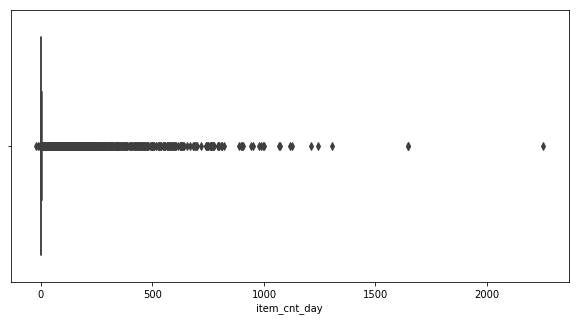

In [6]:
# Plot the distribution of item_cnt_day
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(sales_train['item_cnt_day'])

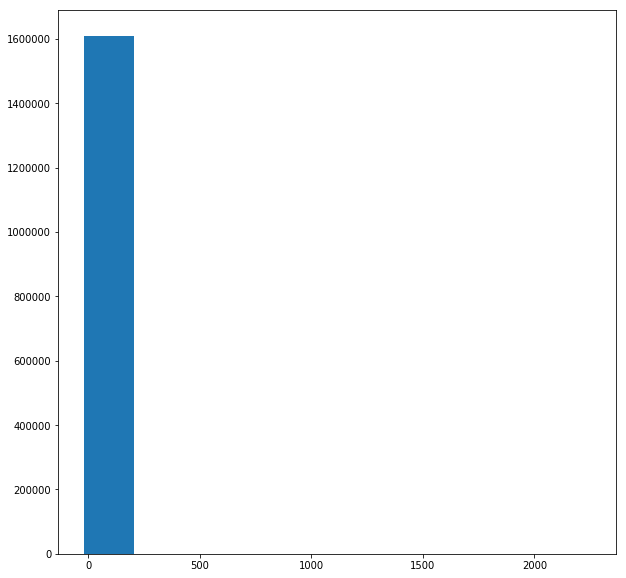

In [7]:
_ = plt.figure(figsize=(10,10))
_ = plt.hist(sales_train['item_cnt_day'])

In [8]:
sales_train.item_cnt_day.describe()

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_day, dtype: float64

By looking at the distribution of ``item_cnt_day``, it's shown that the data is skewed heavily to the right with a bunch of outliers. From letting these outliers skew the analysis and model, it may be necessary to remove these observations. There are many different ways decide what is considered an outlier but for this project, anything roughly 3 standard deviations from the mean will be considered an outlier which is around 30. Another thing to notice is that there are negative ``item_cnt_day`` values which could also skew the analysis. These values might indicate returns or a simple input error but these values will also be removed.

In [9]:
sales_train = sales_train[(sales_train['item_cnt_day'] < 30) & (sales_train['item_cnt_day'] >= 0)]

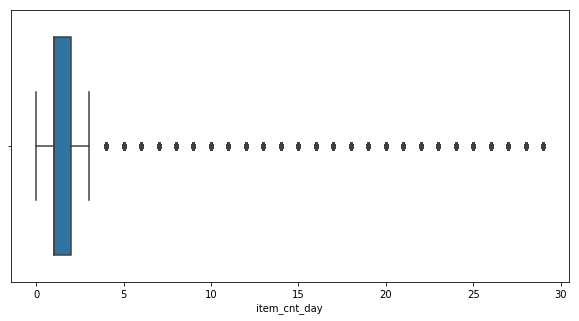

In [10]:
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(sales_train['item_cnt_day'])

In [11]:
_ = plt.figure(figsize=(12,12))
_ = plt.hist(sales_train['item_cnt_day'])

# ``shop_id`` Analysis

In [12]:
# Plot availability of shop_id by month
_ = plt.figure(figsize=(12,12))
_ = plt.scatter(x = 'date_block_num', y = 'shop_id', data = sales_train)
_ = plt.title('Shop Availability by Month')
_ = plt.xlabel('date_block_num')
_ = plt.ylabel('shop_id')

From the plot above, it's clear that there are a handful of shops that aren't open consistently, while ``shop_id``'s like 0, 1, and 8 haven't been open since early 2013. For purposes of this problem, it may not be necessary to predict sales from shops that aren't in the test set. This would isolate trends on those specific shops while cutting back on time, computation speed, and efficiency. If the goal of the project was to predict the future sales of all ``shop_id`` then removing the shops wouldn't be recommended.

In [13]:
# Remove shop_id not found in test set from train set
## Obtain list of shop_id in test set
test_shops = sales_test['shop_id'].unique()

## Filter out shop_id not in test_shops
sales_train_filter_shops = sales_train[sales_train['shop_id'].isin(test_shops)]

print(len(sales_train_filter_shops))
print(len(sales_train_filter_shops['shop_id'].unique()))

1317747
42


After removing the shops that don't appear in the test set, the training set has been reduced by nearly 300,000 observations (~18%) and from 59 unique ``shop_id``'s to 42. The same process could be done to the ``item_id``/``item_category_id`` column to isolate how well items or item categories tend to trend.

In [14]:
# Sum item_cnt_day in sales_train_filtered by date and shop_id
shops_grouped = sales_train_filter_shops[['date_block_num', 'shop_id', 'item_cnt_day', 'profits']].groupby(['date_block_num', 'shop_id']).sum()

# Input missing values for months where shop_id's weren't open/available
## Initialize empty data frame with same multilevel index
shops_index_iter = [list(range(0,34)), test_shops]
shops_index = pd.MultiIndex.from_product(shops_index_iter, names=['date_block_num', 'shop_id'])
sales_train_shop_grouped = pd.DataFrame(index = shops_index)

# Outer merge empty data frame with shops_grouped
sales_train_shop_grouped = pd.merge(sales_train_shop_grouped, shops_grouped, how='outer',on=['date_block_num', 'shop_id']).sort_index()

# Fill NAN values with 0 indicating no sales/not open
sales_train_shop_grouped.fillna(0, inplace=True)

# Reset index
sales_train_shop_grouped.reset_index(inplace=True)

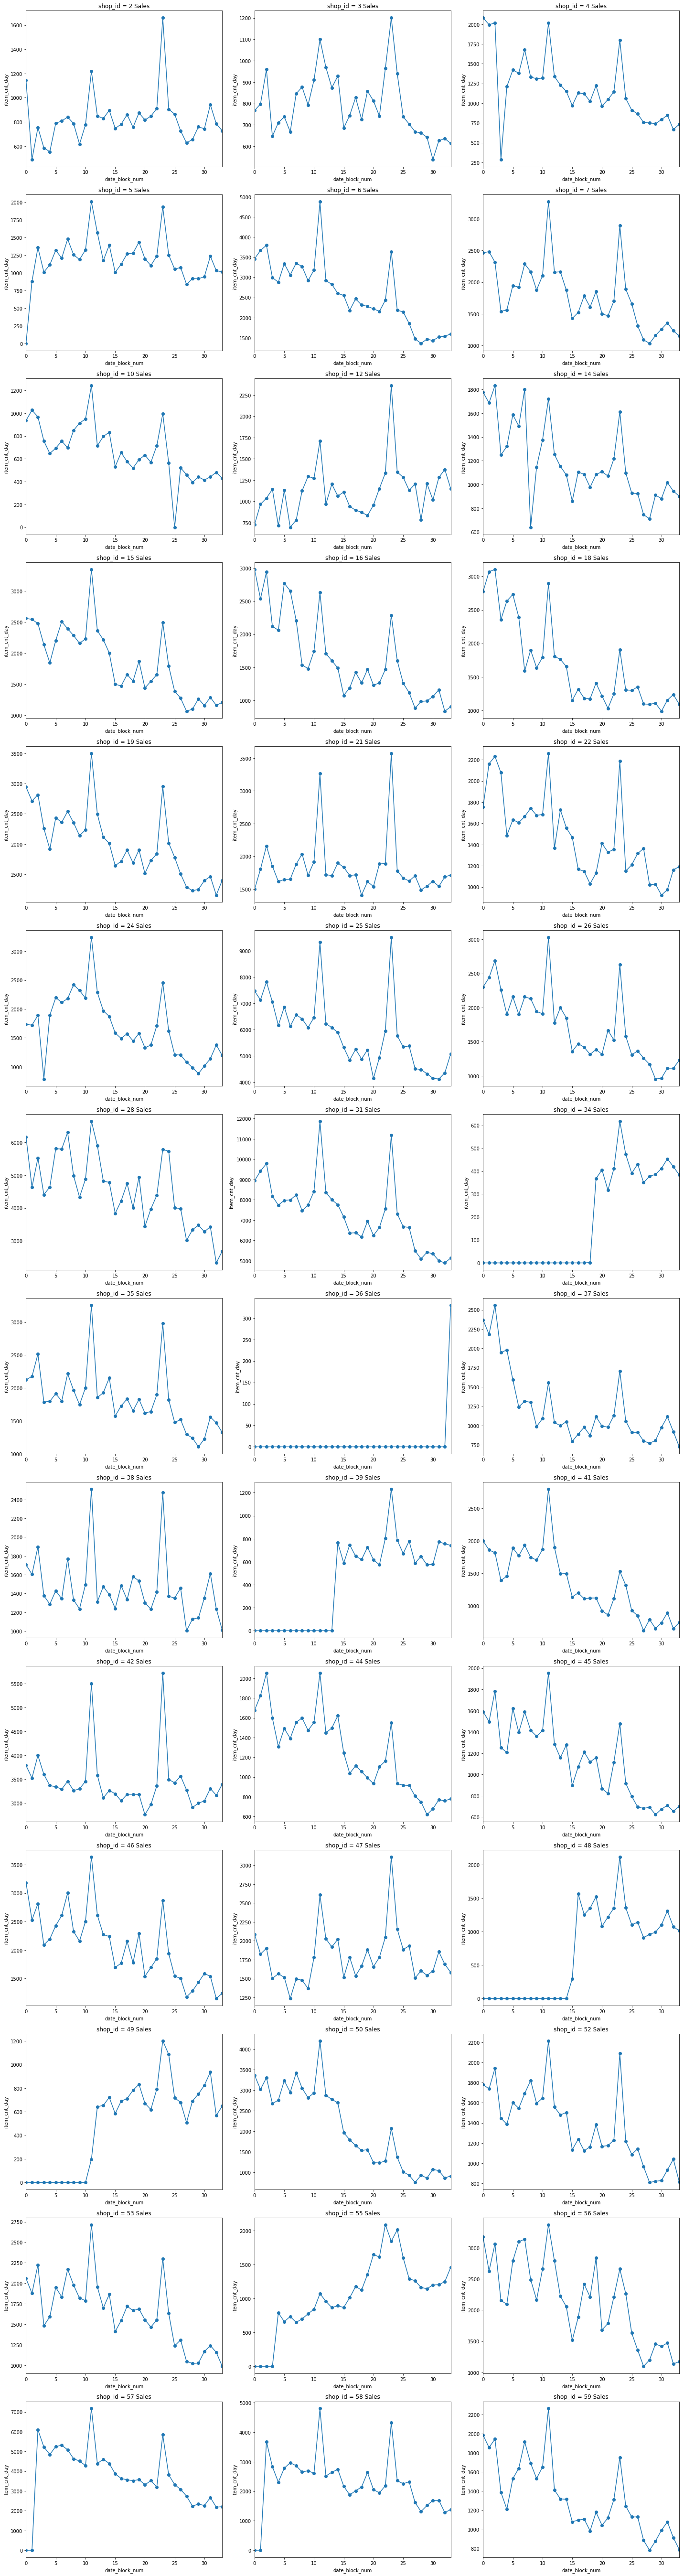

In [15]:
# Plot total item_cnt_day per date_block_num by shop_id
_ = plt.figure(figsize=(20,75))
for i in range(len(sales_train_shop_grouped['shop_id'].unique())):
    shop = sorted(sales_train_shop_grouped['shop_id'].unique())[i]
    shop_sales = sales_train_shop_grouped[sales_train_shop_grouped['shop_id'] == shop]
    
    _ = plt.subplot(14, 3, i+1)
    _ = plt.plot(shop_sales['date_block_num'], shop_sales['item_cnt_day'], marker='o')
    _ = plt.title('shop_id = %i Sales' %shop)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('item_cnt_day')
    _ = plt.xlim(0, 33)

_ = plt.tight_layout()

In [16]:
# Plot total profits per date_block_num by shop_id
_ = plt.figure(figsize=(20,75))
for i in range(len(sales_train_shop_grouped['shop_id'].unique())):
    shop = sorted(sales_train_shop_grouped['shop_id'].unique())[i]
    shop_sales = sales_train_shop_grouped[sales_train_shop_grouped['shop_id'] == shop]
    
    _ = plt.subplot(14, 3, i+1)
    _ = plt.plot(shop_sales['date_block_num'], shop_sales['profits'], marker='o')
    _ = plt.title('shop_id = %i Sales' %shop)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('profits')
    _ = plt.xlim(0, 33)

_ = plt.tight_layout()

By looking at these plots, it appears that most shops have peak sales around a ``date_block_num`` of 11 and 23 which represents December is those years. One thing to pay attention to in the plots are that the scales aren't the same between shops but it's to illustrate the trends of each shop.

## ``item_category_id`` Analysis

In [17]:
# Remove item_id not found in test set from train set
## Obtain list of item_id in test set
test_item_cats = sales_test['item_category_id'].unique()

## Filter out item_id not in test_shops
sales_train_filter_cats = sales_train[sales_train['item_category_id'].isin(test_item_cats)]

print(len(sales_train_filter_cats))
print(len(sales_train_filter_cats['item_category_id'].unique()))

1585769
62


In [18]:
# Sum item_cnt_day in sales_train_filtered by date and item_category_id
cats_grouped = sales_train_filter_cats[['date_block_num', 'item_category_id', 'item_cnt_day', 'profits']].groupby(['date_block_num', 'item_category_id']).sum()

# Input missing values for months where item_category_id's weren't open/available
## Initialize empty data frame with same multilevel index
cats_index_iter = [list(range(0,34)), test_item_cats]
cats_index = pd.MultiIndex.from_product(cats_index_iter, names=['date_block_num', 'item_category_id'])
sales_train_cat_grouped = pd.DataFrame(index = cats_index)

# Outer merge empty data frame with cats_grouped
sales_train_cat_grouped = pd.merge(sales_train_cat_grouped, cats_grouped, how='outer',on=['date_block_num', 'item_category_id']).sort_index()

# Fill NAN values with 0 indicating no sales/not available
sales_train_cat_grouped.fillna(0, inplace=True)

# Reset index
sales_train_cat_grouped.reset_index(inplace=True)

In [19]:
_ = plt.figure(figsize=(20,100))
for i in range(len(sales_train_cat_grouped['item_category_id'].unique())):
    item_cat = sorted(sales_train_cat_grouped['item_category_id'].unique())[i]
    item_cat_sales = sales_train_cat_grouped[sales_train_cat_grouped['item_category_id'] == item_cat]
    
    _ = plt.subplot(21, 3, i+1)
    _ = plt.plot(item_cat_sales['date_block_num'], item_cat_sales['item_cnt_day'], marker='o')
    _ = plt.title('item_category_id = %i Sales' %item_cat)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('item_cnt_day')
    _ = plt.xlim(0, 33)

_ = plt.tight_layout()

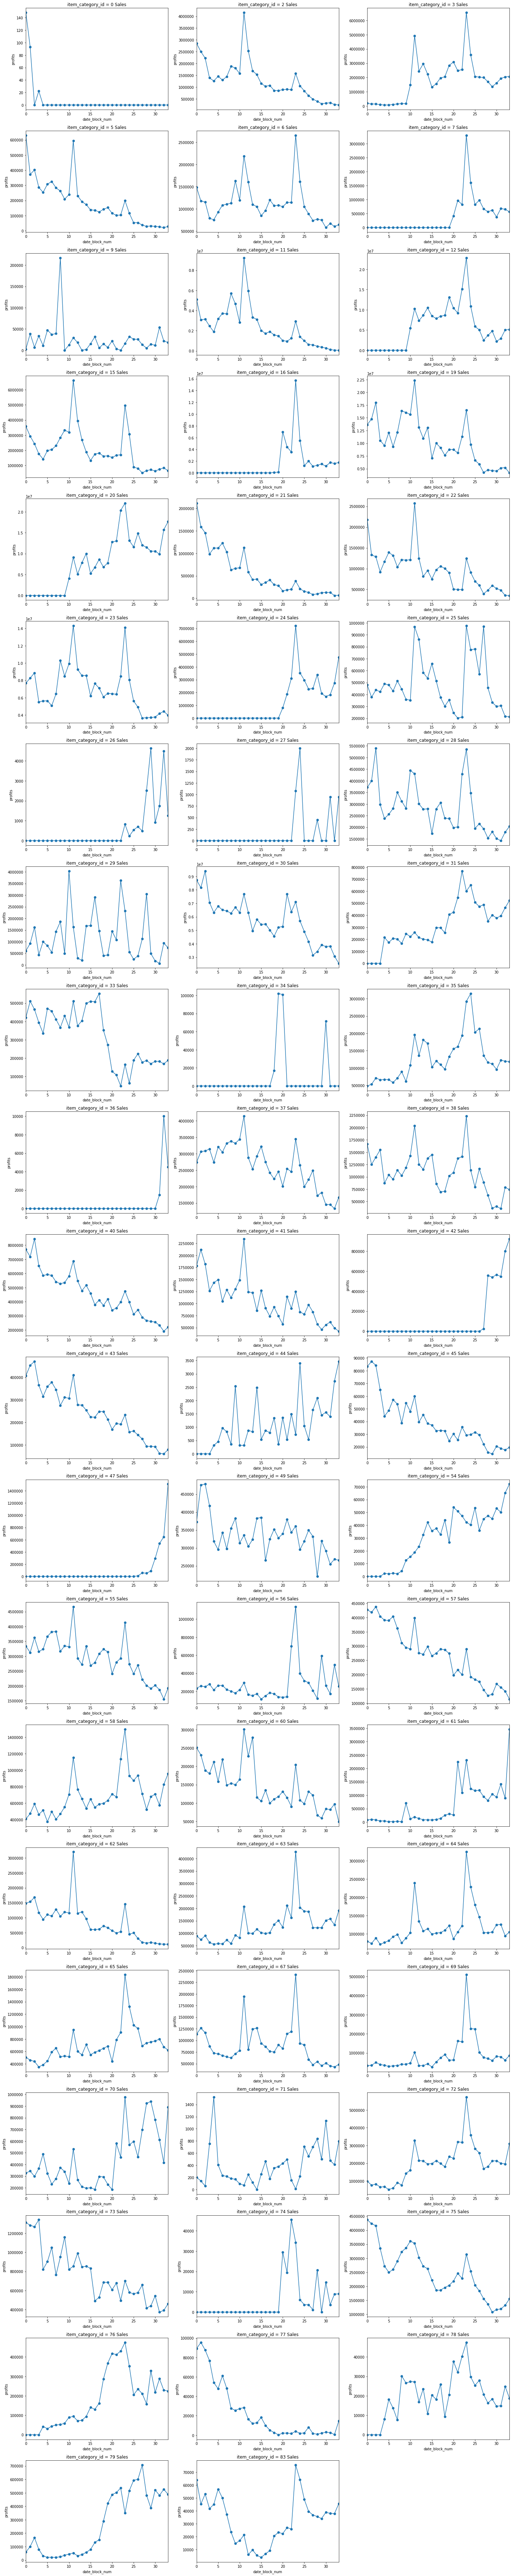

In [20]:
_ = plt.figure(figsize=(20,100))
for i in range(len(sales_train_cat_grouped['item_category_id'].unique())):
    item_cat = sorted(sales_train_cat_grouped['item_category_id'].unique())[i]
    item_cat_sales = sales_train_cat_grouped[sales_train_cat_grouped['item_category_id'] == item_cat]
    
    _ = plt.subplot(21, 3, i+1)
    _ = plt.plot(item_cat_sales['date_block_num'], item_cat_sales['profits'], marker='o')
    _ = plt.title('item_category_id = %i Sales' %item_cat)
    _ = plt.xlabel('date_block_num')
    _ = plt.ylabel('profits')
    _ = plt.xlim(0, 33)

_ = plt.tight_layout()

Just like when analyzing shops, there are peak times when ``item_category_id``'s tend to sell more with a few exeptional categories with underlying trends to their sales. Categories 9, 28, and 38 appear to perform randomly throughout whereas categories 44, 57, and 77 seem to have downward or upward trends. Next will be to analyze if these items statistically sell more during November/December compared to the rest of the year.

## Monthly Analysis

As shown in the above analysis, items tend to sell well towards the end of the year, mainly in December months. Next will be to visualize how well each month did.

In [21]:
# Calculate average and total item_cnt_day by month of year
mean_monthly_cnt = sales_train.groupby(sales_train['date_block_num'] % 12)['item_cnt_day'].mean()
total_monthly_cnt = sales_train.groupby(sales_train['date_block_num'] % 12)['item_cnt_day'].sum()

In [22]:
# Plot average item_cnt_day by month of year
_ = plt.figure(figsize=(10,10))
_ = plt.plot(mean_monthly_cnt)
_ = plt.title('Average item_cnt_day by Month')
_ = plt.xlabel('Month')
_ = plt.ylabel('Average item_cnt_day')

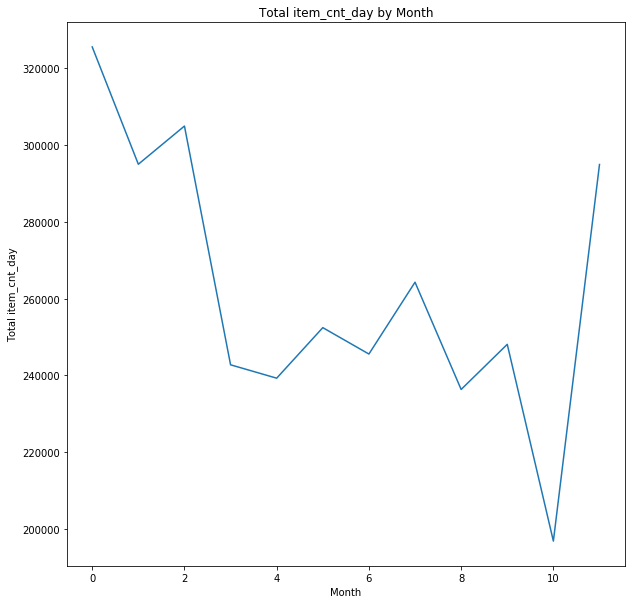

In [23]:
# Plot total item_cnt_day by month of year
_ = plt.figure(figsize=(10,10))
_ = plt.plot(total_monthly_cnt)
_ = plt.title('Total item_cnt_day by Month')
_ = plt.xlabel('Month')
_ = plt.ylabel('Total item_cnt_day')

From the two plots above, it's clear that sales go up as it gets closer to December. The reason for a spike in the beginning of the year in the total ``item_cnt_day`` plot is because the data was taken from January 2013 to October 2015, so November and December numbers only account for two years worth of data.

When calculating for average profit by month of year, a total of each month must be taken first before moving forward in the analysis. Thats because the data needs to be grouped by month first or the mean will produce the mean of each transaction. This way, the overall profit for each month would be aggregated and then the average of each month of year could be taken.

In [24]:
# Calculate total profit by month. This will be later used to get average profits by month of year
monthly_profit = sales_train.groupby(sales_train['date_block_num'])['profits'].sum()

In [25]:
# Calculate average profit by month of year
mean_monthly_profit = monthly_profit.groupby(monthly_profit.index % 12).mean()

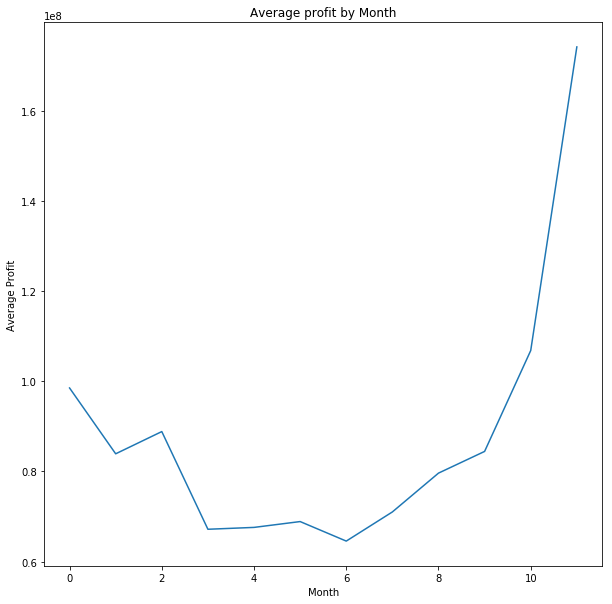

In [26]:
# Plot average profit by month of year
_ = plt.figure(figsize=(10,10))
_ = plt.plot(mean_monthly_profit)
_ = plt.title('Average profit by Month')
_ = plt.xlabel('Month')
_ = plt.ylabel('Average Profit')

In [27]:
# Calculate total profit by month of year
total_monthly_profit = monthly_profit.groupby(monthly_profit.index % 12).sum()

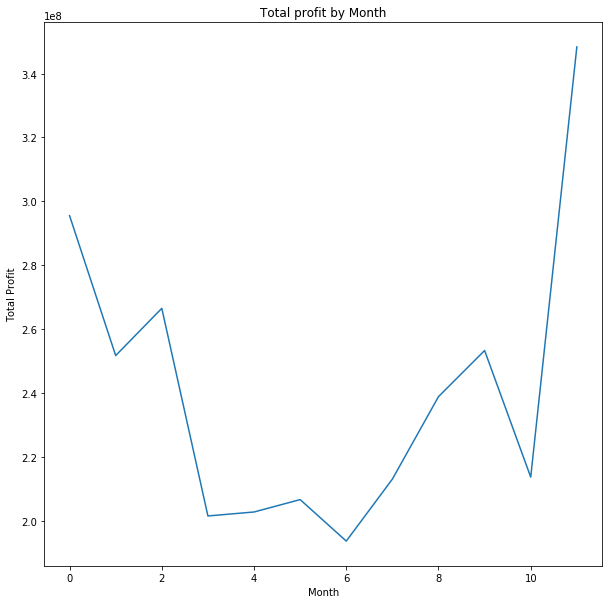

In [28]:
# Plot total profit by month of year
_ = plt.figure(figsize=(10,10))
_ = plt.plot(total_monthly_profit)
_ = plt.title('Total profit by Month')
_ = plt.xlabel('Month')
_ = plt.ylabel('Total Profit')

Yet again, December seems to be the best producing month of the year being the highest overall earner and getting the highest earning on average.